# Classifier with Continuous Actions

**idea:** classifier $c(x, a)$ predicts expected costs for taking an action $a$ when observing $x$

1. Sample from prior $\theta\sim p(\theta)$
2. Get observations from simulator $x\sim p(x|\theta)$
3. Sample actions $a\sim p(a)$
4. Train a neural network
    - feed forward NN with $x$ and $a$ as input
    - trained to predict the expected costs
    - loss L2 loss



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

from loss_calibration.classifier_continuous import train, build_classifier
from loss_calibration.loss import SquaredLoss, RevGaussLoss
import loss_calibration.toy_example as toy
from loss_calibration.utils import load_data
from sbi.utils import BoxUniform
from sbi.utils.torchutils import atleast_2d
from loss_calibration.actions import get_action_distribution, preselect_actions
from sbi.utils.sbiutils import gradient_ascent


## Toy Example

#### Toy Example and Actions

In [3]:
prior = toy.get_prior()
simulator = toy.get_simulator()

# uniform distribution for actions
def get_action(size:int, low=0., high = 5.):
    samples =  BoxUniform([low], [high]).sample((size, ))
    return samples 

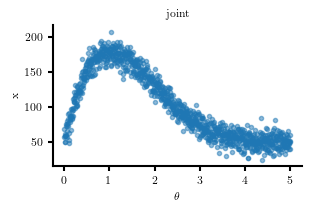

In [4]:
with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(3,2))
    thetas = torch.linspace(0, 5, 1000)
    ax.scatter(thetas, simulator(thetas), alpha=0.5); 
    ax.set_xlabel(r'$\theta$'); ax.set_ylabel('x'); ax.set_title('joint')
    #plt.savefig('results/1d_classifier/1D_clf_joint.pdf')
    plt.show()

#### Cost function

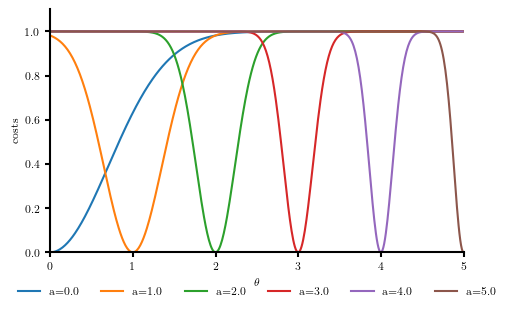

In [5]:
#loss = SquaredLoss(factor=1)
loss = RevGaussLoss(factor=1)
with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
        low, high = 0., 5.
        resolution = 500
        thetas = torch.arange(low, high, (high - low) / resolution)

        fig, ax = plt.subplots(1, 1, figsize=(5,3))
        for a in torch.arange(0,5.1,1):
                plt.plot(thetas, loss(thetas, a), label=f'a={a}')

        plt.xlabel(r'$\theta$')
        plt.ylabel('costs')
        plt.xlim(low, high)
        plt.ylim(0,1.1)
        plt.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, -0.1),
            fancybox=True,
            shadow=True,
            ncol=6,
        )
        plt.savefig("./results/continuous/toy_example/fig_cost_fct.pdf")
        plt.show()

#### Data Set

Get data from task

In [6]:
theta_train, x_train, theta_val, x_val, theta_test, x_test = load_data("toy_example")
theta_train = theta_train[:50_000]
x_train = x_train[:50_000]
theta_val = theta_val[:5_000]
x_val = x_val[:5_000]
theta_test = theta_test[:5_000]
x_test = x_test[:5_000]

Load data from './data/toy_example', device = cpu.


sample random actions and 

In [8]:
preselect = False
if not preselect: 
    actions_train = get_action(theta_train.shape[0])
    costs_train = loss(theta_train, actions_train)
else: 
    n_select = 2
    actions_train, costs_train = preselect_actions(loss, theta_train, n_sample=10, n_select=n_select)
    actions_train = actions_train.reshape(-1,1)
    costs_train = costs_train.reshape(-1,1)
    x_train = x_train.repeat(1,n_select).reshape(-1,1)
    theta_train = theta_train.repeat(1,n_select).reshape(-1,1)

actions_val = get_action(theta_val.shape[0])
costs_val = loss(theta_val, actions_val)

actions_test = get_action(theta_test.shape[0])
costs_test = loss(theta_test, actions_test)


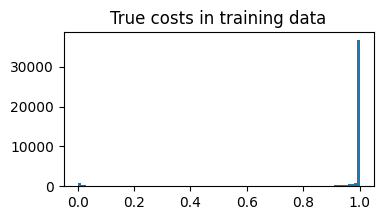

In [9]:
plt.figure(figsize=(4,2))
plt.hist(costs_train.numpy(), bins=100)
plt.title('True costs in training data')
plt.show()

#### Classifier

In [10]:
torch.manual_seed(8639)

clf = build_classifier("fc", x_train, actions_train, hidden_dims=[50,50,50], output_dim=1, activation=nn.ReLU(), output_transform=nn.Identity())
print(clf, end="\n-----\n")

clf, train_loss, val_loss = train(
    clf,
    x_train,
    actions_train,
    costs_train,
    x_val,
    actions_val,
    costs_val,
    learning_rate=1e-3,
    model_dir="./results/continuous/toy_example",
    max_num_epochs=800,
    stop_after_epochs=50,
)

FeedforwardNN(
  (standardize_layer): Standardize()
  (input_layer): Linear(in_features=2, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (final_layer): Linear(in_features=50, out_features=1, bias=True)
  (activation): ReLU()
  (output_transform): Identity()
)
-----
Converged after 302 epochs. train_loss = 0.04064902	 last_improvement = 48


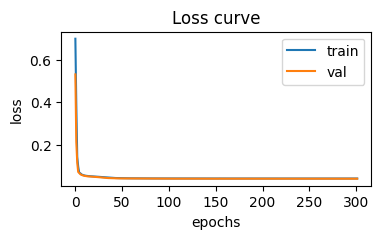

In [11]:
fig, ax = plt.subplots(1,1, figsize = (4,2))
ax.plot(train_loss, label="train")
ax.plot(val_loss, label = "val")
ax.set_title("Loss curve"); ax.set_xlabel("epochs"); ax.set_ylabel("loss")
ax.legend()
plt.savefig("./results/continuous/toy_example/fig_loss_curve.pdf")
plt.show()

##### Check predictions on training data

In [12]:
predictions_train = clf(x_train, actions_train)

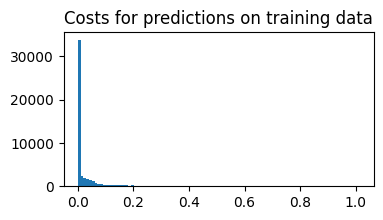

In [260]:
losses_train = torch.mean((costs_train - predictions_train)**2, dim=1)
#torch.median(losses_train), torch.mean(losses_train)
plt.figure(figsize=(4,2))
plt.hist(losses_train.detach().numpy(), bins=100)
plt.title("Costs for predictions on training data")
plt.show()

### Posterior and Expected Costs

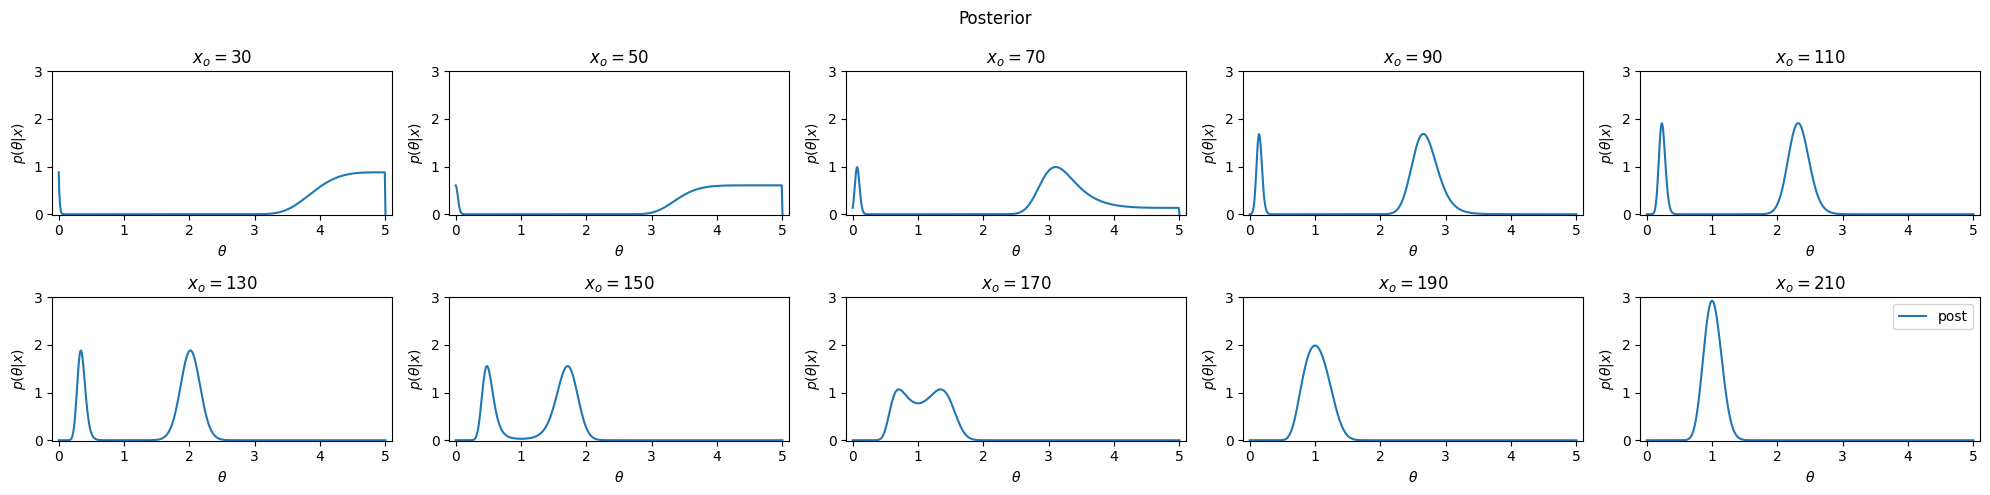

In [15]:
obs = torch.arange(30, 230, 20)
#a_o = 4
lower, upper = 0., 5.
theta_grid = torch.linspace(lower, upper, resolution).unsqueeze(1)

plt.figure(figsize=(20,5))
for i, x_o in enumerate(obs): 
    plt.subplot(2,5,i+1%5)

    post = toy.gt_posterior(x_o, lower, upper, resolution)
    plt.plot(theta_grid, post, label='post')

    #true_costs_taking_a = toy.evaluate_cost(theta_grid, actions=a_o)
    #plt.plot(theta_grid, true_costs_taking_a, label='costs')


    plt.xlabel(r'$\theta$'); plt.ylabel(r'$p(\theta|x)$')
    plt.title(rf'$x_o=${x_o}')
    plt.xlim(-0.1,5.1); plt.ylim(-0.01,3)
plt.suptitle("Posterior")
plt.tight_layout()
plt.legend()
plt.savefig("./results/continuous/toy_example/fig_posterior.pdf")
plt.show()

#### Exemplary posterior and costs

In [16]:
a_o = 1.7
x_o = torch.tensor([170.]) 

In [17]:
lower, upper = 0., 5.
theta_grid = torch.linspace(lower, upper, resolution).unsqueeze(1)
post = toy.gt_posterior(x_o, lower, upper, resolution)

In [18]:
true_costs_taking_a = toy.evaluate_cost(theta_grid, actions=a_o)

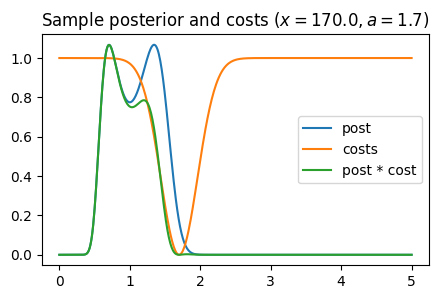

In [19]:
plt.figure(figsize=(5,3))
plt.plot(theta_grid, post, label='post')
plt.plot(theta_grid, true_costs_taking_a, label='costs')
plt.plot(theta_grid, (post * true_costs_taking_a ), label='post * cost')
plt.legend()
plt.title(rf"Sample posterior and costs ($x={x_o.item()}, a={a_o}$)")
plt.savefig("./results/continuous/toy_example/fig_post_cost.pdf")
plt.show()

In [20]:
toy.expected_posterior_loss(x_o, a_o)

tensor(0.7655)

#### Expected Costs

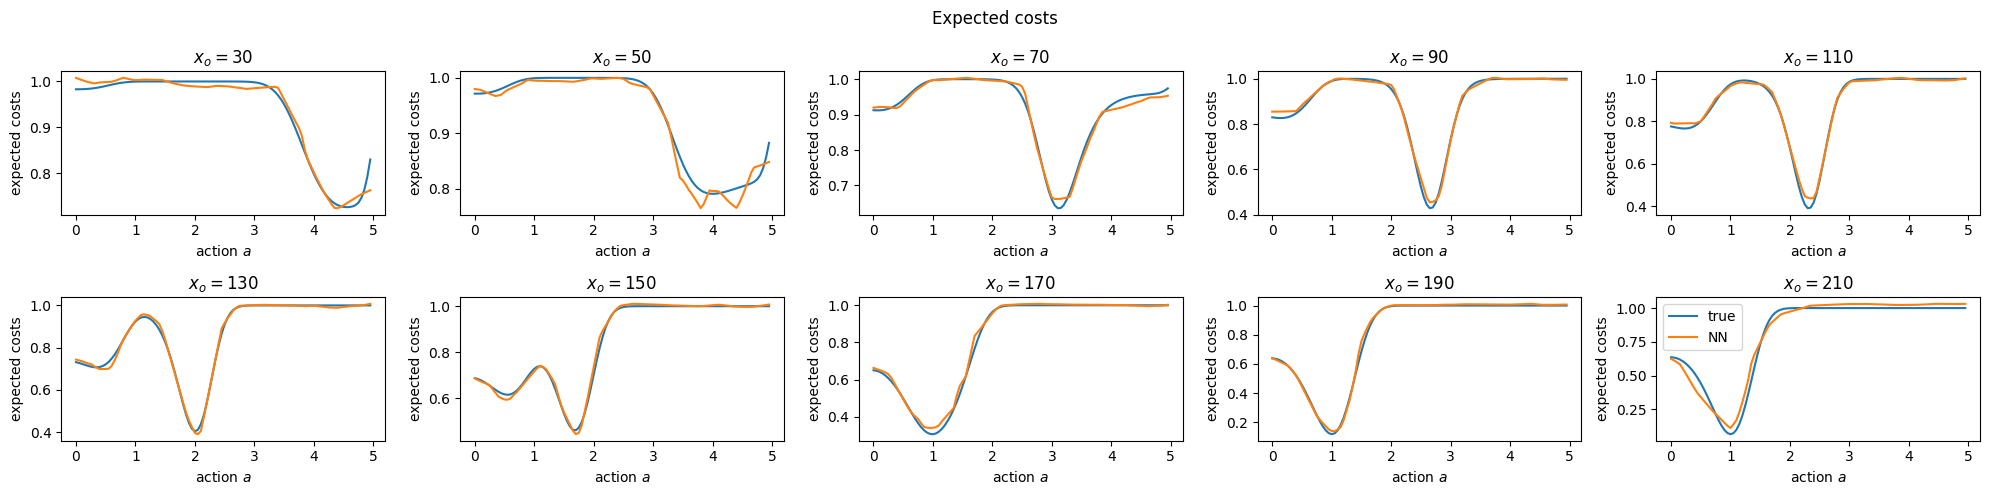

In [21]:
obs = torch.arange(30, 230, 20)
a_grid = torch.arange(0.,5.,0.05)

plt.figure(figsize=(20,5))
for i, x_o in enumerate(obs): 
    plt.subplot(2,5,i+1%5)

    expected_posterior_losses = torch.tensor(
        [
            toy.expected_posterior_loss(
                x_o=x_o,
                a_o=a,
                lower=lower,
                upper=upper,
                resolution=resolution,
            )
            for a in a_grid
        ]
    )
    
    predicted_losses = torch.tensor([clf(atleast_2d(x_o), atleast_2d(a)) for a in a_grid])


    plt.plot(a_grid, expected_posterior_losses, label="true")
    plt.plot(a_grid, predicted_losses, label="NN")
    plt.xlabel(r'action $a$'); plt.ylabel('expected costs')
    plt.title(rf'$x_o=${x_o}')
plt.suptitle("Expected costs")
plt.tight_layout()
plt.legend()
plt.savefig("./results/continuous/toy_example/fig_expected_costs.pdf")
plt.show()

#### Check divergence from optimal action and costs

Difference in optimal action

In [22]:
obs_grid = torch.arange(0, 220, 5)
a_grid = torch.arange(0.0, 5.0, 0.05)

expected_posterior_losses = [
    torch.tensor(
        [
            toy.expected_posterior_loss(
                x_o=x_o,
                a_o=a,
                lower=lower,
                upper=upper,
                resolution=resolution,
            )
            for a in a_grid
        ]
    ).unsqueeze(0)
    for x_o in obs_grid
]
expected_posterior_losses = torch.concat(expected_posterior_losses, dim=0)
predicted_losses = [
    torch.tensor([clf(x_o.reshape(-1,1), a.reshape(-1,1)) for a in a_grid])
    for x_o in obs_grid
]
predicted_losses = torch.stack(predicted_losses, dim=0)


a_gt = a_grid[expected_posterior_losses.argmin(dim=1)]
a_predicted = a_grid[predicted_losses.argmin(dim=1)]

In [23]:
(a_gt - a_predicted).abs().mean()

tensor(0.0909)

Differrence in expected costs of the optimal action

In [24]:
torch.tensor(
    [
        (toy.expected_posterior_loss(x_o, a_true) - toy.expected_posterior_loss(x_o, a_pred)).abs()
        for x_o, a_true, a_pred in zip(obs_grid, a_gt, a_predicted)
    ]
).mean()

tensor(0.0119)

#### Gradient Descent to find optimal action

As potential function, use the reverse expected costs, rescaled by the maximum:

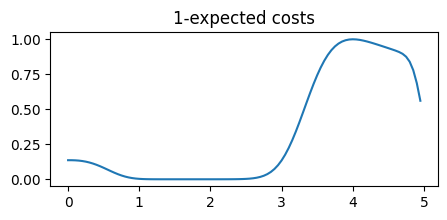

In [312]:
obs = torch.tensor([50.])
a_grid = torch.arange(0.,5.,0.05)

plt.figure(figsize=(5,2))

expected_posterior_losses = torch.tensor(
        [
            toy.expected_posterior_loss(
                x_o=obs,
                a_o=a,
                lower=lower,
                upper=upper,
                resolution=resolution,
            )
            for a in a_grid
        ]
    )
predicted_losses = torch.tensor([clf(obs.unsqueeze(0), a.unsqueeze(0).unsqueeze(0)) for a in a_grid])

reverse_costs = (1 - expected_posterior_losses)
plt.title("1-expected costs")
plt.plot(a_grid, reverse_costs/reverse_costs.max(), label="true")
plt.show()

In [313]:
def expected_costs(x: torch.Tensor, a: torch.Tensor, use_posterior=False) -> torch.Tensor:
    if x.ndim < 2:
        x = x.reshape(-1, 1)
    if a.ndim < 2:
        a = a.reshape(-1, 1)

    a_dist = get_action_distribution()
    l, u = a_dist.base_dist.low, a_dist.base_dist.high
    # TODO: example-specific grid
    costs = torch.zeros_like(a)
    inside_range = torch.logical_and(a >= l, a <= u).flatten()
    a_valid = a[inside_range]

    costs[torch.logical_not(inside_range)] = torch.inf
    if use_posterior:
        costs[inside_range] = torch.vstack([toy.expected_posterior_loss(obs, av) for av in a_valid])
    else: 
        costs[inside_range] = clf(obs.repeat(a_valid.shape[0], 1), a_valid)

    return costs.flatten()


def reverse_costs(x: torch.Tensor, a: torch.Tensor, use_posterior: bool=False) -> torch.Tensor:
    return 1 - expected_costs(x, a, use_posterior)

#expected_costs_given_x = partial(reverse_costs, obs)
# expected_costs_given_x(a=a)
reverse_costs_given_x_nn = partial(reverse_costs, obs, use_posterior=False)
reverse_costs_given_x_post = partial(reverse_costs, obs, use_posterior=True)



In [314]:
initial_actions = get_action(100)
gd_best_action_nn, gd_costs_nn = gradient_ascent(potential_fn=reverse_costs_given_x_nn, inits=initial_actions, theta_transform=None)
gd_best_action_nn, gd_costs_nn

(tensor([3.8139]), tensor([0.2365]))

In [315]:
reverse_costs_given_x = partial(reverse_costs, obs, use_posterior=True)
gd_best_action_post, gd_costs_post = gradient_ascent(potential_fn=reverse_costs_given_x_post, inits=initial_actions, theta_transform=None)
gd_best_action_post, gd_costs_post

(tensor([4.0019]), tensor([0.2087]))

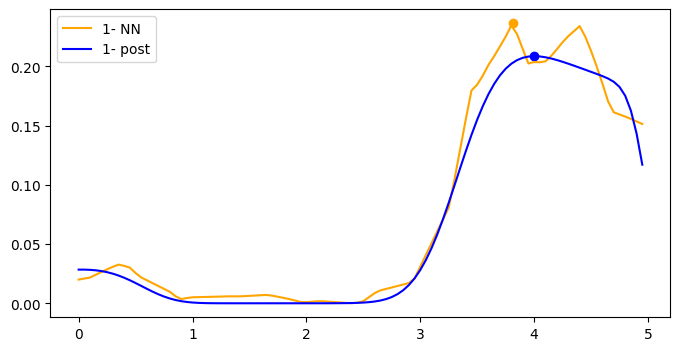

In [316]:
plt.figure(figsize=(8,4))

expected_posterior_losses = torch.tensor(
        [
            toy.expected_posterior_loss(
                x_o=obs,
                a_o=a,
                lower=lower,
                upper=upper,
                resolution=resolution,
            )
            for a in a_grid
        ]
    )
predicted_losses = torch.tensor([clf(obs.unsqueeze(0), a.unsqueeze(0).unsqueeze(0)) for a in a_grid])

reverse_costs = (1 - expected_posterior_losses)
#plt.plot(a_grid, reverse_costs/reverse_costs.max(), label="true")
plt.scatter(gd_best_action_post, gd_costs_post, c='b')
plt.scatter(gd_best_action_nn, gd_costs_nn, c='orange')

plt.plot(a_grid, 1-predicted_losses, label="1- NN", c='orange')
plt.plot(a_grid, reverse_costs, label="1- post", c='b')
plt.legend()
#plt.plot(a_grid, predicted_losses, label="NN")
plt.show()

### Sequential Action Selection


In [ ]:
n_rounds = 3

for r in range(1, n_rounds +1):
    print(f"\n----- ROUND {r} -----")
    # sample actions using the expected costs
    


In [303]:
from sbi.inference import RejectionPosterior
from sbi.inference.potentials.base_potential import BasePotential


In [304]:
class AcquisitionPotential(BasePotential):
    allow_iid_x = False

    def __init__(self, prior, x_o, acquisition_fn, device="cpu"):
        super().__init__(prior, x_o, device=device)
        self.acquisition_fn = acquisition_fn

    def __call__(self, theta, track_gradients=True):
        with torch.set_grad_enabled(track_gradients):
            return torch.log(self.acquisition_fn(theta))

In [305]:
potential_fn = AcquisitionPotential(get_action_distribution(), obs, reverse_costs_given_x_nn)

In [306]:
acquisition_sampler = RejectionPosterior(
                potential_fn=potential_fn, proposal=get_action_distribution
            )

In [26]:
import numpy as np
import scipy as sp



In [27]:
import torch

In [64]:
normal = sp.stats.norm
uni = sp.stats.uniform

density = normal
num_samples: int = 10#0
x_start: int = -5
x_end: int = 5
x_intervals: int = 100#0

x_vec = np.linspace(x_start, x_end, x_intervals)

density_vals = density.pdf(x_vec)

cdf_vals = np.cumsum(density_vals)
cdf_vals = cdf_vals / np.max(cdf_vals)

base_samples = np.random.rand(num_samples)
tiled_cdf = np.tile(cdf_vals, (num_samples, 1))
tiled_samples = np.tile(base_samples, (x_intervals, 1))

# dist_func = np.abs(tiled_samples - tiled_cdf.T)
# min_index = np.argmin(dist_func, axis=0)

# samples = x_vec[min_index]


In [71]:
cdf_vals.shape

(100,)

In [66]:
base_samples

array([0.3106852 , 0.11132255, 0.28786201, 0.90323714, 0.77429568,
       0.95061366, 0.98092096, 0.84411143, 0.64330117, 0.46057086])

In [69]:
tiled_cdf.shape


(10, 100)

In [70]:
tiled_samples.shape

(100, 10)